In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### EDA: admissions data from mimic-3

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/619_nlp/MIMIC-III/ADMISSIONS.csv', parse_dates = ['ADMITTIME', 'DISCHTIME','DEATHTIME'], infer_datetime_format = True, engine = "c")
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   datetime64[ns]
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [ ]:
df.isna().sum()

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

##### Creating a subset of df with only columns that are required:

In [ ]:
adm = df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME','DEATHTIME', 'ADMISSION_TYPE']]
adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBJECT_ID      58976 non-null  int64         
 1   HADM_ID         58976 non-null  int64         
 2   ADMITTIME       58976 non-null  datetime64[ns]
 3   DISCHTIME       58976 non-null  datetime64[ns]
 4   DEATHTIME       5854 non-null   datetime64[ns]
 5   ADMISSION_TYPE  58976 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.7+ MB


The next step is to get the next unplanned admission date if it exists. In order to do this, we need to sort by SUBJECT_ID and ADMITTIME.

In [ ]:
adm = adm.sort_values(by=['SUBJECT_ID','ADMITTIME'])
adm = adm.reset_index(drop = True)

In [ ]:
adm.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY


In [ ]:
adm['NEXT_ADMITTIME'] = adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

In [ ]:
adm.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT


In [ ]:
adm.tail(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME
58966,99973,150202,2180-11-27 02:30:00,2180-12-01 13:42:00,NaT,EMERGENCY,NaT
58967,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,NaT,EMERGENCY,2157-01-05 17:27:00
58968,99982,112748,2157-01-05 17:27:00,2157-01-12 13:00:00,NaT,EMERGENCY,2157-02-16 17:31:00
58969,99982,183791,2157-02-16 17:31:00,2157-02-22 20:36:00,NaT,EMERGENCY,NaT
58970,99983,117390,2193-04-26 11:35:00,2193-04-29 13:30:00,NaT,EMERGENCY,NaT
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaT,EMERGENCY,NaT
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaT,ELECTIVE,NaT
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaT,EMERGENCY,NaT
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaT,ELECTIVE,NaT
58975,99999,113369,2117-12-30 07:15:00,2118-01-04 16:30:00,NaT,ELECTIVE,NaT


In [ ]:
adm['NEXT_ADM_TYPE'] = adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
adm.tail(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE
58966,99973,150202,2180-11-27 02:30:00,2180-12-01 13:42:00,NaT,EMERGENCY,NaT,NaN
58967,99982,151454,2156-11-28 11:56:00,2156-12-08 13:45:00,NaT,EMERGENCY,2157-01-05 17:27:00,EMERGENCY
58968,99982,112748,2157-01-05 17:27:00,2157-01-12 13:00:00,NaT,EMERGENCY,2157-02-16 17:31:00,EMERGENCY
58969,99982,183791,2157-02-16 17:31:00,2157-02-22 20:36:00,NaT,EMERGENCY,NaT,NaN
58970,99983,117390,2193-04-26 11:35:00,2193-04-29 13:30:00,NaT,EMERGENCY,NaT,NaN
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaT,EMERGENCY,NaT,NaN
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaT,ELECTIVE,NaT,NaN
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaT,EMERGENCY,NaT,NaN
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaT,ELECTIVE,NaT,NaN
58975,99999,113369,2117-12-30 07:15:00,2118-01-04 16:30:00,NaT,ELECTIVE,NaT,NaN


In [ ]:
adm.head(100)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN
...,...,...,...,...,...,...,...,...
95,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY,2176-09-02 14:22:00,EMERGENCY
96,94,140037,2176-09-02 14:22:00,2176-09-25 13:15:00,NaT,EMERGENCY,NaT,NaN
97,95,160891,2157-12-25 16:28:00,2157-12-27 15:25:00,NaT,EMERGENCY,NaT,NaN
98,96,170324,2156-03-31 16:11:00,2156-04-29 15:05:00,NaT,EMERGENCY,NaT,NaN


In [ ]:
# remove data for which next_adm_type is an elective visit, since elective visits don't count as readmissions
rows = adm['NEXT_ADM_TYPE'] == 'ELECTIVE'
adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
adm.loc[rows,'NEXT_ADM_TYPE'] = np.NaN

In [ ]:
adm.head(100)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN
...,...,...,...,...,...,...,...,...
95,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY,2176-09-02 14:22:00,EMERGENCY
96,94,140037,2176-09-02 14:22:00,2176-09-25 13:15:00,NaT,EMERGENCY,NaT,NaN
97,95,160891,2157-12-25 16:28:00,2157-12-27 15:25:00,NaT,EMERGENCY,NaT,NaN
98,96,170324,2156-03-31 16:11:00,2156-04-29 15:05:00,NaT,EMERGENCY,NaT,NaN


In [ ]:
adm['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [ ]:
adm = adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])

#backfill ## slow
adm[['NEXT_ADMITTIME', 'NEXT_ADM_TYPE']] = adm.groupby(['SUBJECT_ID']) [['NEXT_ADMITTIME','NEXT_ADM_TYPE']].fillna(method = 'bfill')

In [ ]:
adm.head(100)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN
...,...,...,...,...,...,...,...,...
95,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY,2176-09-02 14:22:00,EMERGENCY
96,94,140037,2176-09-02 14:22:00,2176-09-25 13:15:00,NaT,EMERGENCY,NaT,NaN
97,95,160891,2157-12-25 16:28:00,2157-12-27 15:25:00,NaT,EMERGENCY,NaT,NaN
98,96,170324,2156-03-31 16:11:00,2156-04-29 15:05:00,NaT,EMERGENCY,NaT,NaN


In [ ]:
(adm['NEXT_ADMITTIME'][58967] - adm['DISCHTIME'][58967]).days

28

In [ ]:
(adm['NEXT_ADMITTIME'][58966] - adm['DISCHTIME'][58966]).days

nan

In [ ]:
adm['DAYS_NEXT_ADMIT'] = (adm['NEXT_ADMITTIME'] - adm['DISCHTIME']).dt.days

In [ ]:
adm.head(50)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE,DAYS_NEXT_ADMIT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,NaT,NaN,NaN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN,NaT,NaN,NaN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN,NaT,NaN,NaN
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN


## EDA for note events tabel from mimic-3

In [ ]:
use_cols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'TEXT']

In [ ]:
notes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/619_nlp/MIMIC-III/NOTEEVENTS.csv', usecols = use_cols, engine='c', low_memory=False)

In [ ]:
notes.head(10)

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...
5,53181,170490.0,Discharge summary,Admission Date: [**2172-3-5**] D...
6,20646,134727.0,Discharge summary,Admission Date: [**2112-12-8**] ...
7,42130,114236.0,Discharge summary,Admission Date: [**2150-2-25**] ...
8,56174,163469.0,Discharge summary,Admission Date: [**2118-8-10**] ...
9,56174,189681.0,Discharge summary,Admission Date: [**2118-12-7**] ...


In [ ]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     float64
 2   CATEGORY    object 
 3   TEXT        object 
dtypes: float64(1), int64(1), object(2)
memory usage: 63.6+ MB


In [ ]:
notes.shape

(2083180, 4)

In [ ]:
notes['CATEGORY'].value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [ ]:
notes_dis = notes[notes['CATEGORY'] == 'Discharge summary']

In [ ]:
notes_dis.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [ ]:
notes_dis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59652 entries, 0 to 60415
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SUBJECT_ID  59652 non-null  int64  
 1   HADM_ID     59652 non-null  float64
 2   CATEGORY    59652 non-null  object 
 3   TEXT        59652 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
notes_dis.shape

(59652, 4)

Get only last discharge notes for each adm_id for same patient

In [ ]:
notes_dis_last = (notes_dis.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()

In [ ]:
notes_dis_last.head(10)

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,3,145834.0,Discharge summary,Admission Date: [**2101-10-20**] Discharg...
1,4,185777.0,Discharge summary,Admission Date: [**2191-3-16**] Discharge...
2,6,107064.0,Discharge summary,Admission Date: [**2175-5-30**] Dischar...
3,9,150750.0,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi..."
4,10,184167.0,Discharge summary,Admission Date: [**2103-6-28**] Dischar...
5,11,194540.0,Discharge summary,Admission Date: [**2178-4-16**] ...
6,12,112213.0,Discharge summary,Admission Date: [**2104-8-7**] Discharge ...
7,13,143045.0,Discharge summary,"Name: [**Known lastname 9900**], [**Known fir..."
8,17,161087.0,Discharge summary,Admission Date: [**2135-5-9**] D...
9,17,194023.0,Discharge summary,Admission Date: [**2134-12-27**] ...


In [ ]:
notes_dis_last.shape

(52726, 4)

In [ ]:
notes_dis_last.duplicated(['HADM_ID']).sum()

0

## Merging adm & note events df

In [ ]:
adm_notes = pd.merge(adm, notes_dis_last, on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [ ]:
adm_notes.shape

(58976, 11)

In [ ]:
adm_notes['TEXT'].isnull().sum()

6250

In [ ]:
adm_notes['TEXT'].isnull().sum() / len(adm_notes)
# 10% are null notes

0.1059753119913185

In [ ]:
# check which type of adm has no discharge summary
adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g['TEXT'].isnull().sum())

ADMISSION_TYPE
ELECTIVE      375
EMERGENCY    1598
NEWBORN      4220
URGENT         57
dtype: int64

In [ ]:
adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [ ]:
adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [ ]:
adm_notes_clean = adm_notes.loc[adm_notes['ADMISSION_TYPE'] != "NEWBORN"]
adm_notes_clean.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2191-3-16**] Discharge...
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,Discharge summary,Admission Date: [**2175-5-30**] Dischar...
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi..."
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2178-4-16**] ...
10,12,112213,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,ELECTIVE,NaT,NaN,NaN,Discharge summary,Admission Date: [**2104-8-7**] Discharge ...
11,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,"Name: [**Known lastname 9900**], [**Known fir..."
13,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,NaT,ELECTIVE,2135-05-09 14:11:00,EMERGENCY,128.0,Discharge summary,Admission Date: [**2134-12-27**] ...
14,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2135-5-9**] D...
15,18,188822,2167-10-02 11:18:00,2167-10-04 16:15:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,"Name: [**Known lastname 4919**] JR,[**Known f..."


In [ ]:
adm_notes_clean['OUTPUT_LABEL'] = (adm_notes_clean['DAYS_NEXT_ADMIT'] < 30).astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
adm_notes_clean.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [ ]:
adm_notes_clean['OUTPUT_LABEL'].value_counts()

0    48109
1     3004
Name: OUTPUT_LABEL, dtype: int64

In [ ]:
adm_notes_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51113 entries, 1 to 58975
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SUBJECT_ID       51113 non-null  int64         
 1   HADM_ID          51113 non-null  int64         
 2   ADMITTIME        51113 non-null  datetime64[ns]
 3   DISCHTIME        51113 non-null  datetime64[ns]
 4   DEATHTIME        5792 non-null   datetime64[ns]
 5   ADMISSION_TYPE   51113 non-null  object        
 6   NEXT_ADMITTIME   11169 non-null  datetime64[ns]
 7   NEXT_ADM_TYPE    11169 non-null  object        
 8   DAYS_NEXT_ADMIT  11169 non-null  float64       
 9   CATEGORY         49083 non-null  object        
 10  TEXT             49083 non-null  object        
 11  OUTPUT_LABEL     51113 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int64(3), object(4)
memory usage: 5.1+ MB


In [ ]:
adm_notes_clean.to_pickle('/content/drive/My Drive/Colab Notebooks/619_nlp/adm_notes_clean.pkl')

## Cleaning before starting with BoW

In [ ]:
adm_notes_clean_unpickled = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/619_nlp/adm_notes_clean.pkl')

In [ ]:
adm_notes_clean_unpickled.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADM_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [ ]:
X = adm_notes_clean_unpickled.loc[:, 'TEXT']
y = adm_notes_clean_unpickled.loc[:, 'OUTPUT_LABEL']

In [ ]:
print(X.head())
print(y.head())

1    Admission Date:  [**2101-10-20**]     Discharg...
2    Admission Date:  [**2191-3-16**]     Discharge...
4    Admission Date: [**2175-5-30**]        Dischar...
7    Name:  [**Known lastname 10050**], [**Known fi...
9    Admission Date:  [**2178-4-16**]              ...
Name: TEXT, dtype: object
1    0
2    0
4    0
7    0
9    0
Name: OUTPUT_LABEL, dtype: int64


In [ ]:
X[1]

"Admission Date:  [**2101-10-20**]     Discharge Date:  [**2101-10-31**]\n\nDate of Birth:   [**2025-4-11**]     Sex:  M\n\nService:  Medicine\n\nCHIEF COMPLAINT:  Admitted from rehabilitation for\nhypotension (systolic blood pressure to the 70s) and\ndecreased urine output.\n\nHISTORY OF PRESENT ILLNESS:  The patient is a 76-year-old\nmale who had been hospitalized at the [**Hospital1 190**] from [**10-11**] through [**10-19**] of [**2101**]\nafter undergoing a left femoral-AT bypass graft and was\nsubsequently discharged to a rehabilitation facility.\n\nOn [**2101-10-20**], he presented again to the [**Hospital1 346**] after being found to have a systolic\nblood pressure in the 70s and no urine output for 17 hours.\nA Foley catheter placed at the rehabilitation facility\nyielded 100 cc of murky/brown urine.  There may also have\nbeen purulent discharge at the penile meatus at this time.\n\nOn presentation to the Emergency Department, the patient was\nwithout subjective complaints.  I

In [ ]:
X = X.apply(lambda x:re.sub('[^a-zA-Z]', " ", str(x)).lower())
X.head()

1    admission date                        discharg...
2    admission date                       discharge...
4    admission date                         dischar...
7    name      known lastname              known fi...
9    admission date                                ...
Name: TEXT, dtype: object

#### Top 30 most common words in corpus (before applying stemmer):

In [ ]:
from collections import Counter
Counter(" ".join(X).split()).most_common(30)

[('the', 1706988),
 ('and', 1519243),
 ('to', 1298323),
 ('of', 1248979),
 ('was', 1165566),
 ('with', 922456),
 ('a', 862751),
 ('on', 791798),
 ('in', 719466),
 ('mg', 692388),
 ('for', 670883),
 ('no', 594437),
 ('tablet', 549015),
 ('name', 544802),
 ('is', 489516),
 ('patient', 482964),
 ('s', 448410),
 ('po', 421233),
 ('he', 420229),
 ('blood', 394494),
 ('at', 368718),
 ('or', 366921),
 ('she', 350386),
 ('discharge', 349741),
 ('as', 344707),
 ('daily', 340224),
 ('hospital', 334481),
 ('sig', 331176),
 ('day', 314983),
 ('one', 309793)]

In [ ]:
X = X.apply(lambda x:x.split())
X.head()

1    [admission, date, discharge, date, date, of, b...
2    [admission, date, discharge, date, date, of, b...
4    [admission, date, discharge, date, date, of, b...
7    [name, known, lastname, known, firstname, unit...
9    [admission, date, discharge, date, date, of, b...
Name: TEXT, dtype: object

In [ ]:
X_len = X.str.len()

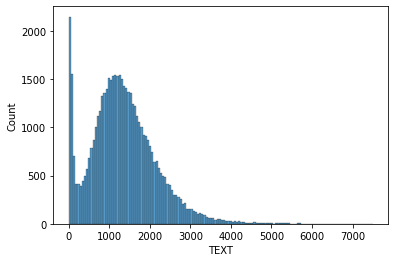

In [ ]:
sns.histplot(data=X_len)

In [ ]:
ss = SnowballStemmer('english')
all_stopwords = stopwords.words('english')

In [ ]:
print ('date' in all_stopwords)
print ('admission' in all_stopwords)
print ('discharge' in all_stopwords)
print ('of' in all_stopwords)

False
False
False
True


In [ ]:
def getStem_removeStop(x):    
    new_list = []
    for word in x:
        if word not in all_stopwords:
            word = ss.stem(word)
            new_list.append(word)
    
    return new_list

In [ ]:
X_ss = X.apply(lambda x:getStem_removeStop(x))

In [ ]:
X_ss.to_pickle('/content/drive/My Drive/Colab Notebooks/619_nlp/X_ss.pkl')

In [ ]:
X_ss_unpickled = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/619_nlp/X_ss.pkl')

In [ ]:
X_ss_unpickled.head()

1    [admiss, date, discharg, date, date, birth, se...
2    [admiss, date, discharg, date, date, birth, se...
4    [admiss, date, discharg, date, date, birth, se...
7    [name, known, lastnam, known, firstnam, unit, ...
9    [admiss, date, discharg, date, date, birth, se...
Name: TEXT, dtype: object

In [ ]:
X_notes = X_ss_unpickled.apply(lambda x:' '.join(x))

In [ ]:
X_notes.head()

1    admiss date discharg date date birth sex servi...
2    admiss date discharg date date birth sex f ser...
4    admiss date discharg date date birth sex f ser...
7    name known lastnam known firstnam unit numer i...
9    admiss date discharg date date birth sex f ser...
Name: TEXT, dtype: object

### Top 30 most common words in corpus (after applying stemming and removing stopwords):

In [ ]:
from collections import Counter
Counter(" ".join(X_notes).split()).most_common(30)

[('mg', 692388),
 ('tablet', 573821),
 ('name', 546872),
 ('patient', 485790),
 ('po', 421234),
 ('day', 403924),
 ('blood', 394534),
 ('discharg', 388784),
 ('hospit', 357821),
 ('daili', 340227),
 ('sig', 331181),
 ('one', 309953),
 ('left', 279614),
 ('last', 269549),
 ('histori', 267787),
 ('medic', 254637),
 ('right', 231133),
 ('time', 217385),
 ('pm', 210812),
 ('pt', 201448),
 ('pain', 199926),
 ('admiss', 190642),
 ('date', 187167),
 ('normal', 175212),
 ('follow', 168744),
 ('p', 166811),
 ('q', 163196),
 ('first', 162728),
 ('ct', 156808),
 ('c', 152640)]

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_notes, y, test_size = 0.30, random_state = 42, stratify = y)

In [ ]:
print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

35779
15334
35779
15334


### Creating the Bag of Words model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 4000, ngram_range=(1, 2))
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

In [ ]:
X_train

<35779x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 20433229 stored elements in Compressed Sparse Row format>

### Model 1: Guassian NB

In [ ]:
X_train.toarray()

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = classifier.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.42%


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10629  3804]
 [  425   476]]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.6323696089543224

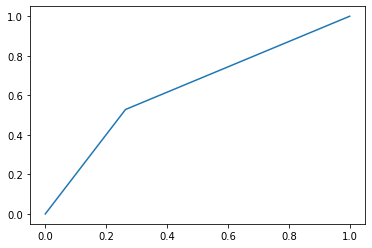

In [ ]:
plt.plot(fpr, tpr)

### Model 2: XgBoost

In [ ]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train.toarray(), y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
acuuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[14423    10]
 [  894     7]]
Accuracy: 94.13%


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.5035381443730236

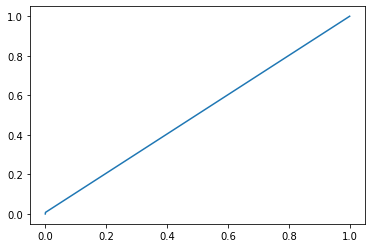

In [ ]:
plt.plot(fpr, tpr)

### Model 3: Logistic Regression

In [ ]:
classifier = LogisticRegression(max_iter=3000)
classifier.fit(X_train.toarray(), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test.toarray())

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[13858   575]
 [  799   102]]
Accuracy: 91.04%


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.536684144956069

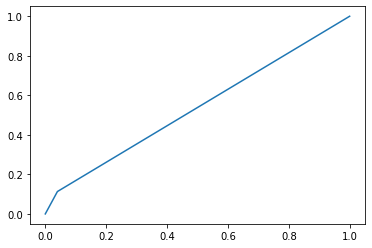

In [ ]:
plt.plot(fpr, tpr)

### Model 4: Random Forest Classifier

In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train.toarray(), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test.toarray())

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[14433     0]
 [  900     1]]
Accuracy: 94.13%


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.5005549389567148

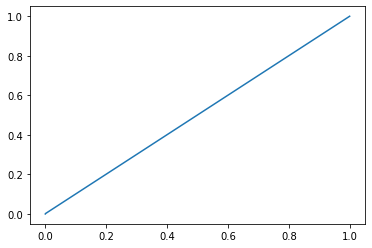

In [ ]:
plt.plot(fpr, tpr)

Summary of all models:
- model 1 Guassian NB : accuracy=72.42% and auc=0.63
- model 2 XGBoost : accuracy=94% and auc=0.50
- model 3 Logistic Regression : accuracy= 91% and auc=0.53
- model 4 Random Forest : accuracy=94.13% and auc=0.50

Model 1 Guassian NB is the best performing model from these 4 models. It doesn't have high accuracy values like the other three models, but it shows better AUC value than all other models.